In [1]:
import json, glob, os, sys
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sys.path.append(CODE) # set sys.path in order to load modules
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2
import system #,container, setup
from scipy.integrate import odeint

In [2]:
def f(X, t, S, k1, k2, k3, kMa, kIa2, kIi2, kRa2, kRi2, kMa2, kMi2):
    # starting values
    R, Ri, I2, M2, R2, Ra = X

    dR  = k3*(1-Ra-R) - k1*S*(1-Ri-Ra)
    dRi = k2*(1-R-Ri) - k3*(1-R-Ra) + kMa*M2*Ra
    dI2 = kIa2*Ra*(1-I2) - kIi2*I2
    dM2 = kMa2*R2*(1-M2) - kMi2*M2
    dR2 = kRa2*I2*(1-R2) - kRi2*R2
    dRa = S*k1*(1-Ra-Ri) - k2*(1-Ri-R) - kMa*M2*Ra

    return(dR, dRi, dI2, dM2, dR2, dRa)

In [3]:
# set parameters


p0=[ 0.123610, 0.772732, 0.104607, 0.903910, 1.033100, 5.04596, 1.002160, 5.75706, 2.51961, 0.000594] #only rates and ODE parameters
Ton=1.0
Amin=0

X0 = [1,0,0,0,0,0] #Rr, Ri, I2, M2, R2, Ra. Assume all receptor starts at Rr, which is what corresponds to the ss if Amin=0
labels=[r"$R_r$", r"$R_i$", r"$I_2$", r"$M_2$", r"$R_2$", r"$R_a$"] #should match order in X0

mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

for ht threshold 0.01, and T=5, habituation time is ht=7 stimuli, and recovery=1271.8 t.u.
for ht threshold 0.01, and T=10, habituation time is ht=9 stimuli, and recovery=1911.27 t.u.
for ht threshold 0.01, and T=15, habituation time is ht=10 stimuli, and recovery=2153.28 t.u.


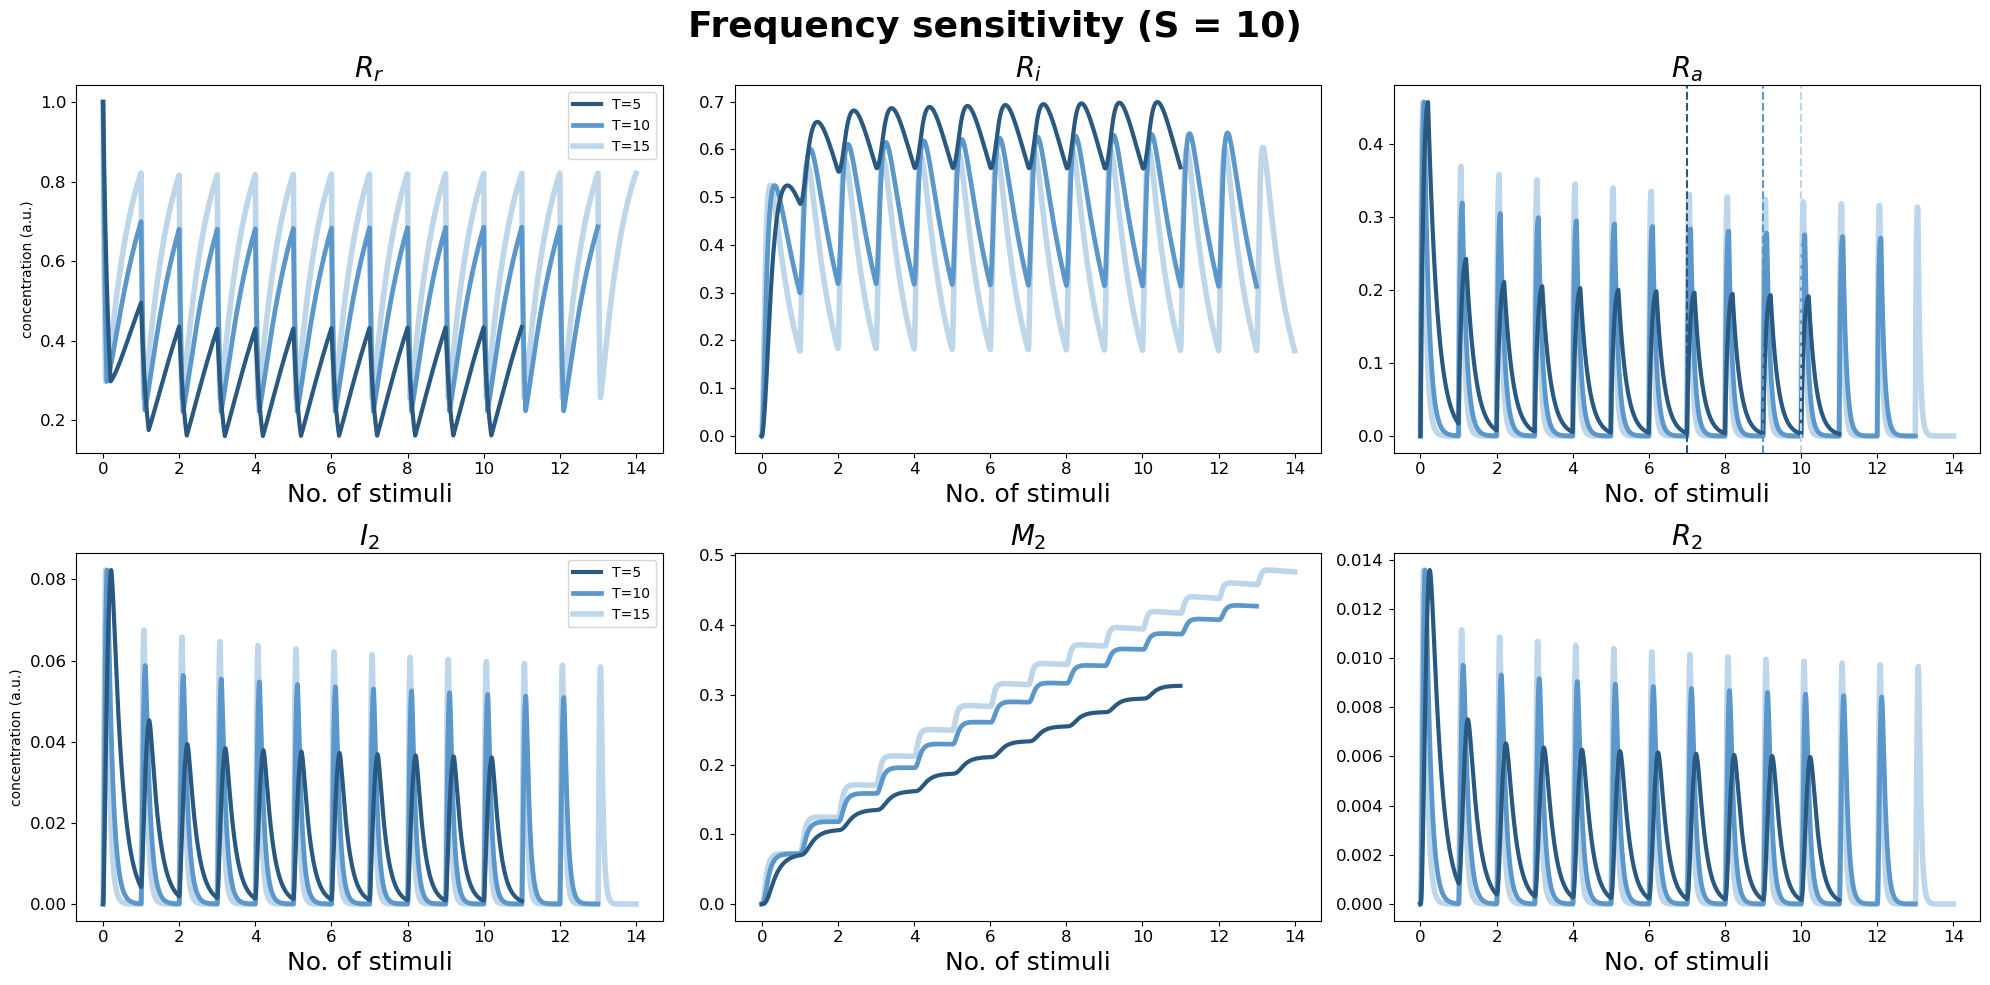

for ht threshold 0.007, and T=5, habituation time is ht=13 stimuli, and recovery=1941.36 t.u.
for ht threshold 0.007, and T=10, habituation time is ht=14 stimuli, and recovery=2358.7 t.u.
for ht threshold 0.007, and T=15, habituation time is ht=14 stimuli, and recovery=2471.4 t.u.


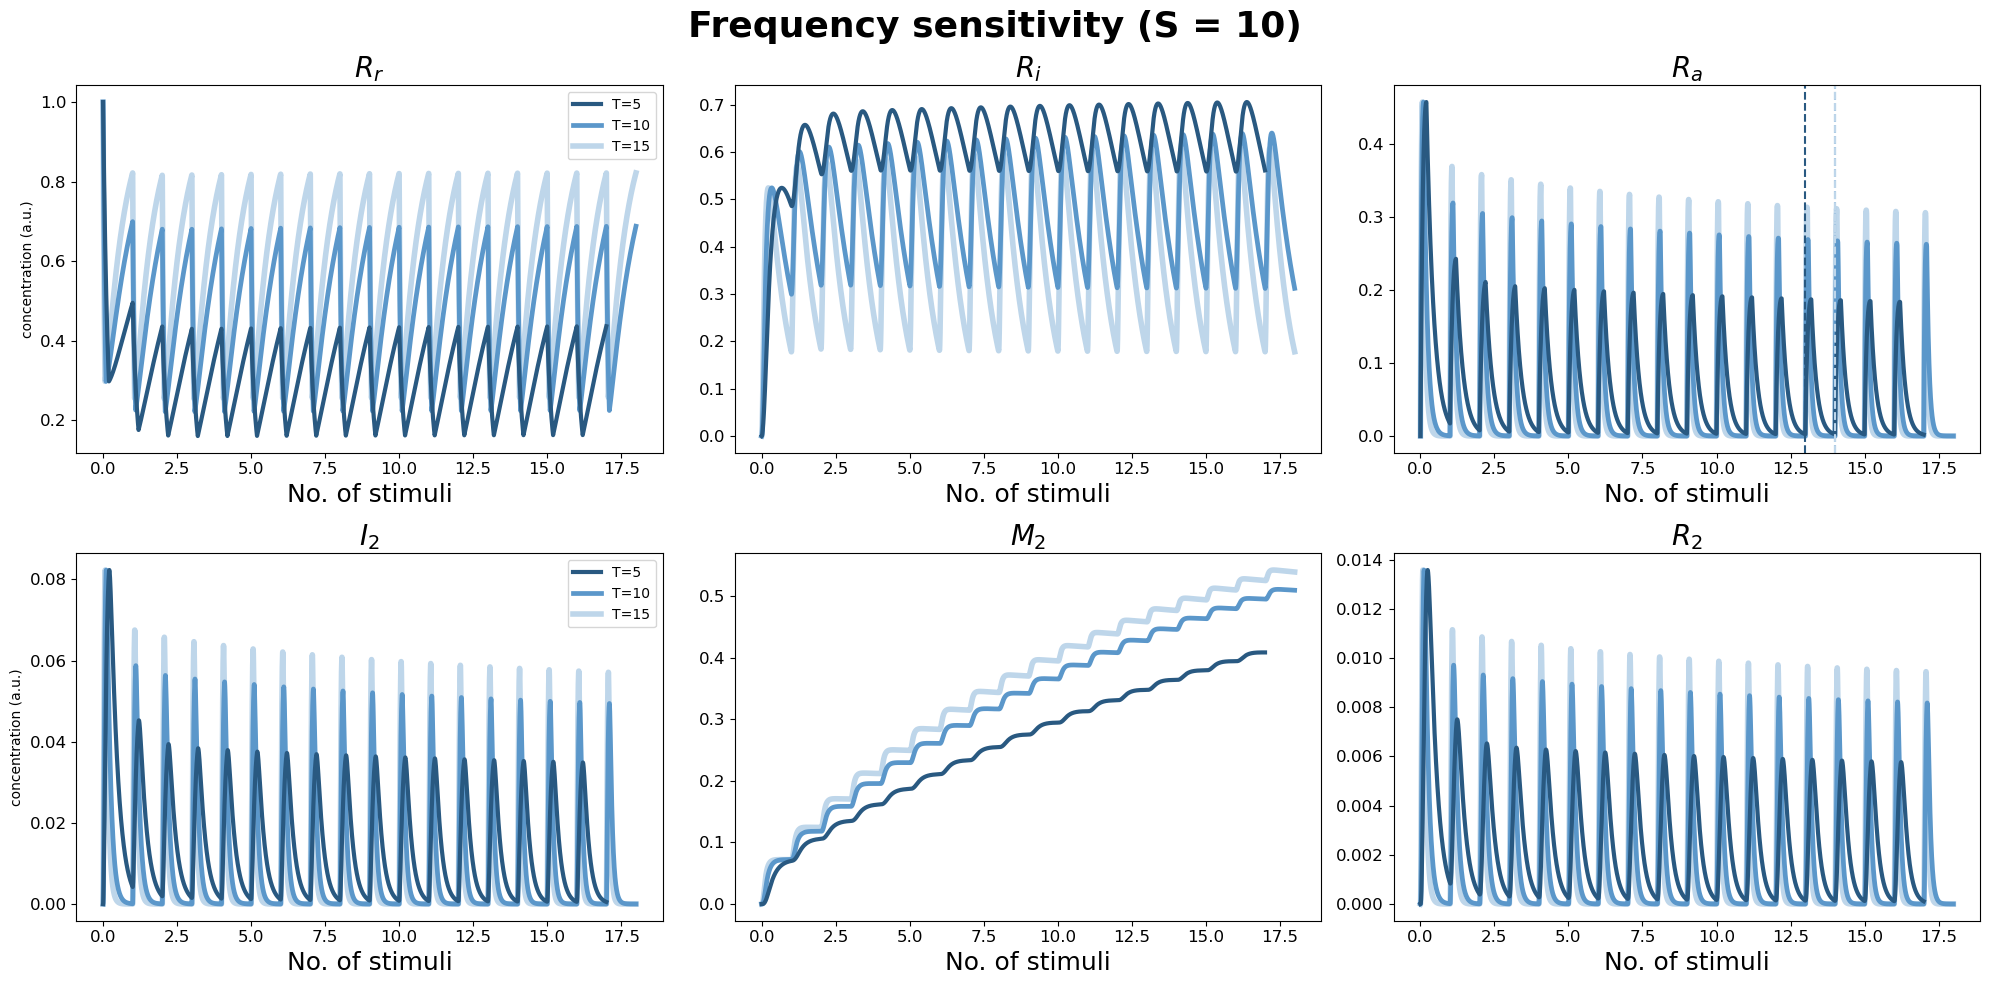

In [4]:
S=10
T_scan_set = [5, 10, 15]
for ht_threshold in [0.01,0.007]:
    traj = []
    tvecs = []
    ht = []
    rt=[]
    for j, T in enumerate(T_scan_set): 
        ht_,rt_=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
        ht.append(ht_)
        rt.append(rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        
        print("for ht threshold %g, and T=%d, habituation time is ht=%d stimuli, and recovery=%g t.u."%(ht_threshold,T,ht_,rt_))
        
    
    plot=True
    if plot:
        # overlay plot for frequency sensitivity
        colors = ['#295981', '#5b97ca', '#bed6ea']
        lw = [2*1.5,2*1.7,2*2]
        al = [1.0,1.0,1.0]

        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

        for j,T in enumerate(T_scan_set):
            y = traj[j]
            tvec = tvecs[j]/T #plot with respect to stimulus number rather than time
            for k in range(0,6):
                #order of variables is #Rr, Ri, I2, M2, R2, Ra . We want to plot Rr, Ri, Ra // I2, M2, R2
                if k==0:
                    ax=axes[0][0]
                elif k==1:
                    ax=axes[0][1]
                elif k==2:
                    ax=axes[1][0] 
                elif k==3:
                    ax=axes[1][1]
                elif k==4:
                    ax=axes[1][2]
                elif k==5:
                    ax=axes[0][2]
                    ax.axvline(x=ht[j],linestyle="--",color=colors[j])
                ax.set_title(labels[k], fontsize=20)
                ax.plot(tvec, y[:,k], color=colors[j], lw=lw[j], alpha=al[j],label="T=%d"%T,zorder=(2-j))


                ax.set_xlabel('No. of stimuli', fontsize=18)
                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)

                if ax==axes[0][0] or ax==axes[1][0]:
                    ax.set_ylabel('concentration (a.u.)')
                    ax.legend()
        #sns.despine()
        fig.suptitle('Frequency sensitivity (S = %d)'%S,  fontweight="bold", fontsize=26)
        plt.tight_layout()
        plt.show()

# Recovery envelope

In [4]:
from scipy.signal import find_peaks
T_scan_set = [5, 10, 15]
S=10
idxm=4 #index of the memory species
ht_threshold=0.01
peak_norm_Ts = []
tperturblist_Ts = []

for T in T_scan_set:
    ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
    #tperturblist=np.linspace(5,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
    tperturblist = np.logspace(np.log10(T), np.log10(rt), 25, endpoint=True)
    tperturblist_Ts.append(tperturblist)
    tvec=mys.computational_data["tvec"]
    htstep=mys.computational_data["habituation_time_step"]
    trajectory=mys.computational_data["trajectory"][:htstep,:]
    habituation_time=mys.computational_data["habituation_time"]
    times_envelope = []
    peaks_envelope = []
    for t in tperturblist:
        tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
        perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
        output_var = perturbational_trajectory[:,mys.output_variable]
        peak, _ = find_peaks(output_var) #, height=0
        lista = output_var[peak]
        lista_times = perturbational_tvec[peak]
        peaks_envelope.append(lista[-1])
        
        all_tvec=tvec[:htstep].copy()
        all_tvec=np.concatenate((all_tvec,tvecr))
        times_envelope.append(lista_times[-1]+all_tvec[-1])
    peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]
    peak_norm_Ts.append(peak_norm)

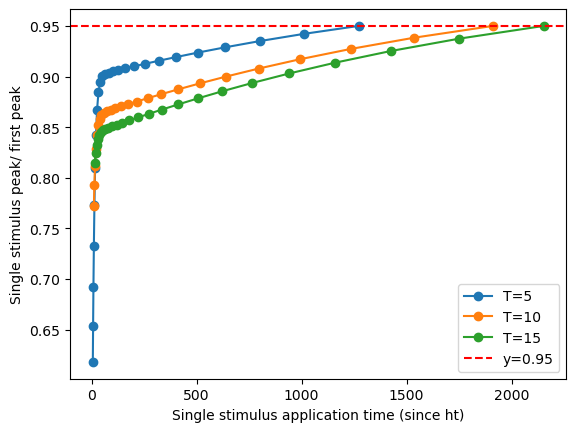

In [5]:
for j,T in enumerate(T_scan_set):
    plt.plot(tperturblist_Ts[j], peak_norm_Ts[j], "o-", label="T=%d"%T)
plt.axhline(y=0.95, color="r", alpha=1.0, ls="--", label = "y=0.95")
plt.xlabel("Single stimulus application time (since ht)")
plt.ylabel("Single stimulus peak/ first peak")
plt.legend()
plt.show()